In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

dataset_dir = '/kaggle/input/cifar-c'
print(os.listdir(dataset_dir))

# Define the path to the subdirectory
sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')

# List contents of the subdirectory
print(os.listdir(sub_dir))

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/866.2 kB ? eta -:--:--

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/866.2 kB 6.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 11.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (320/320), done.


remote: Compressing objects: 100% (241/241), done.


remote: Total 1704 (delta 95), reused 301 (delta 79), pack-reused 1384 (from 1)
Receiving objects: 100% (1704/1704), 518.25 MiB | 46.28 MiB/s, done.
Resolving deltas: 100% (758/758), done.


Updating files: 100% (165/165), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 128

# Use CIFAR-10 dataset for training
baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Use CIFAR-10 dataset for testing
baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1724344597.074270      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:33, 1821572.60it/s]

  1%|          | 1966080/170498071 [00:00<00:16, 10026017.69it/s]

  3%|▎         | 5799936/170498071 [00:00<00:07, 22189120.77it/s]

  5%|▌         | 8912896/170498071 [00:00<00:06, 25519069.18it/s]

  7%|▋         | 12091392/170498071 [00:00<00:05, 27645141.59it/s]

  9%|▉         | 15237120/170498071 [00:00<00:05, 28904081.43it/s]

 11%|█         | 18448384/170498071 [00:00<00:05, 29766328.52it/s]

 13%|█▎        | 21659648/170498071 [00:00<00:04, 30475385.41it/s]

 15%|█▍        | 24838144/170498071 [00:00<00:04, 30769310.40it/s]

 16%|█▋        | 28016640/170498071 [00:01<00:04, 30994444.76it/s]

 18%|█▊        | 31129600/170498071 [00:01<00:04, 30936654.57it/s]

 20%|██        | 34308096/170498071 [00:01<00:04, 31188753.19it/s]

 22%|██▏       | 37453824/170498071 [00:01<00:04, 31257909.63it/s]

 24%|██▍       | 40632320/170498071 [00:01<00:04, 31373945.10it/s]

 26%|██▌       | 43810816/170498071 [00:01<00:04, 31417387.90it/s]

 28%|██▊       | 46956544/170498071 [00:01<00:03, 31199522.78it/s]

 29%|██▉       | 50167808/170498071 [00:01<00:03, 31376490.42it/s]

 31%|███▏      | 53411840/170498071 [00:01<00:03, 31570675.35it/s]

 33%|███▎      | 56655872/170498071 [00:01<00:03, 31821855.61it/s]

 35%|███▌      | 59867136/170498071 [00:02<00:03, 31759497.26it/s]

 37%|███▋      | 63045632/170498071 [00:02<00:03, 31476032.84it/s]

 39%|███▉      | 66289664/170498071 [00:02<00:03, 31699236.32it/s]

 41%|████      | 69566464/170498071 [00:02<00:03, 31995269.72it/s]

 44%|████▎     | 74186752/170498071 [00:02<00:02, 36217168.18it/s]

 47%|████▋     | 80183296/170498071 [00:02<00:02, 43274718.85it/s]

 51%|█████     | 86900736/170498071 [00:02<00:01, 50368765.24it/s]

 55%|█████▌    | 94568448/170498071 [00:02<00:01, 58093375.48it/s]

 60%|██████    | 102367232/170498071 [00:02<00:01, 63952944.75it/s]

 65%|██████▍   | 110526464/170498071 [00:02<00:00, 69193266.08it/s]

 69%|██████▉   | 117866496/170498071 [00:03<00:00, 70418734.63it/s]

 74%|███████▍  | 125861888/170498071 [00:03<00:00, 73261665.95it/s]

 78%|███████▊  | 133627904/170498071 [00:03<00:00, 74515551.56it/s]

 83%|████████▎ | 141295616/170498071 [00:03<00:00, 75116721.35it/s]

 88%|████████▊ | 150208512/170498071 [00:03<00:00, 79303131.83it/s]

 93%|█████████▎| 158892032/170498071 [00:03<00:00, 81533226.30it/s]

 98%|█████████▊| 167411712/170498071 [00:03<00:00, 82590888.89it/s]

100%|██████████| 170498071/170498071 [00:03<00:00, 46295397.19it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:32, 1842747.51it/s]

  1%|▏         | 2392064/170498071 [00:00<00:13, 12404866.15it/s]

  6%|▌         | 10256384/170498071 [00:00<00:03, 41042583.50it/s]

 11%|█▏        | 19234816/170498071 [00:00<00:02, 59196400.94it/s]

 17%|█▋        | 28704768/170498071 [00:00<00:01, 71611846.37it/s]

 22%|██▏       | 37683200/170498071 [00:00<00:01, 77658714.62it/s]

 27%|██▋       | 46497792/170498071 [00:00<00:01, 81004544.06it/s]

 32%|███▏      | 55279616/170498071 [00:00<00:01, 83122636.53it/s]

 38%|███▊      | 64225280/170498071 [00:00<00:01, 84634482.73it/s]

 43%|████▎     | 73695232/170498071 [00:01<00:01, 87656674.65it/s]

 48%|████▊     | 82673664/170498071 [00:01<00:00, 88247847.65it/s]

 54%|█████▎    | 91521024/170498071 [00:01<00:00, 88148677.76it/s]

 59%|█████▉    | 100368384/170498071 [00:01<00:00, 88191013.28it/s]

 64%|██████▍   | 109215744/170498071 [00:01<00:00, 88040519.74it/s]

 70%|██████▉   | 118652928/170498071 [00:01<00:00, 89923727.05it/s]

 75%|███████▍  | 127696896/170498071 [00:01<00:00, 90064059.31it/s]

 80%|████████  | 136708096/170498071 [00:01<00:00, 89508759.76it/s]

 85%|████████▌ | 145686528/170498071 [00:01<00:00, 89156654.75it/s]

 91%|█████████ | 154632192/170498071 [00:01<00:00, 88851230.24it/s]

 96%|█████████▌| 163545088/170498071 [00:02<00:00, 88572642.28it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 80558268.17it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 131072/170498071 [00:00<02:16, 1250701.42it/s]

  1%|          | 983040/170498071 [00:00<00:31, 5433192.91it/s]

  1%|▏         | 2424832/170498071 [00:00<00:17, 9368036.46it/s]

  2%|▏         | 4096000/170498071 [00:00<00:13, 12191979.33it/s]

  4%|▎         | 5996544/170498071 [00:00<00:11, 14610986.73it/s]

  5%|▍         | 8192000/170498071 [00:00<00:09, 17019451.98it/s]

  6%|▋         | 10747904/170498071 [00:00<00:08, 19630749.42it/s]

  8%|▊         | 13598720/170498071 [00:00<00:06, 22416267.33it/s]

 10%|▉         | 16809984/170498071 [00:00<00:06, 25418633.89it/s]

 12%|█▏        | 19922944/170498071 [00:01<00:05, 27018378.65it/s]

 13%|█▎        | 22970368/170498071 [00:01<00:05, 28025656.90it/s]

 15%|█▌        | 26083328/170498071 [00:01<00:05, 28838846.61it/s]

 17%|█▋        | 29163520/170498071 [00:01<00:04, 29366627.77it/s]

 19%|█▉        | 32145408/170498071 [00:01<00:04, 29443957.89it/s]

 21%|██        | 35192832/170498071 [00:01<00:04, 29683913.48it/s]

 23%|██▎       | 38436864/170498071 [00:01<00:04, 30445038.30it/s]

 24%|██▍       | 41484288/170498071 [00:01<00:04, 30250023.32it/s]

 26%|██▌       | 44564480/170498071 [00:01<00:04, 30285917.56it/s]

 28%|██▊       | 48267264/170498071 [00:01<00:03, 32256680.08it/s]

 31%|███       | 52822016/170498071 [00:02<00:03, 36199760.64it/s]

 34%|███▍      | 58032128/170498071 [00:02<00:02, 40932667.23it/s]

 38%|███▊      | 64192512/170498071 [00:02<00:02, 47025659.45it/s]

 42%|████▏     | 71270400/170498071 [00:02<00:01, 54090966.21it/s]

 47%|████▋     | 79527936/170498071 [00:02<00:01, 62606723.60it/s]

 52%|█████▏    | 88440832/170498071 [00:02<00:01, 70076963.28it/s]

 57%|█████▋    | 97353728/170498071 [00:02<00:00, 75749654.39it/s]

 62%|██████▏   | 106233856/170498071 [00:02<00:00, 79141896.70it/s]

 68%|██████▊   | 115638272/170498071 [00:02<00:00, 83508864.24it/s]

 73%|███████▎  | 124354560/170498071 [00:02<00:00, 84562873.93it/s]

 78%|███████▊  | 132841472/170498071 [00:03<00:00, 81643566.11it/s]

 83%|████████▎ | 141033472/170498071 [00:03<00:00, 73231621.27it/s]

 87%|████████▋ | 148537344/170498071 [00:03<00:00, 68612974.09it/s]

 91%|█████████ | 155549696/170498071 [00:03<00:00, 65495484.00it/s]

 95%|█████████▌| 162234368/170498071 [00:03<00:00, 63453245.18it/s]

 99%|█████████▉| 168656896/170498071 [00:03<00:00, 61986083.78it/s]

100%|██████████| 170498071/170498071 [00:03<00:00, 46241103.16it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


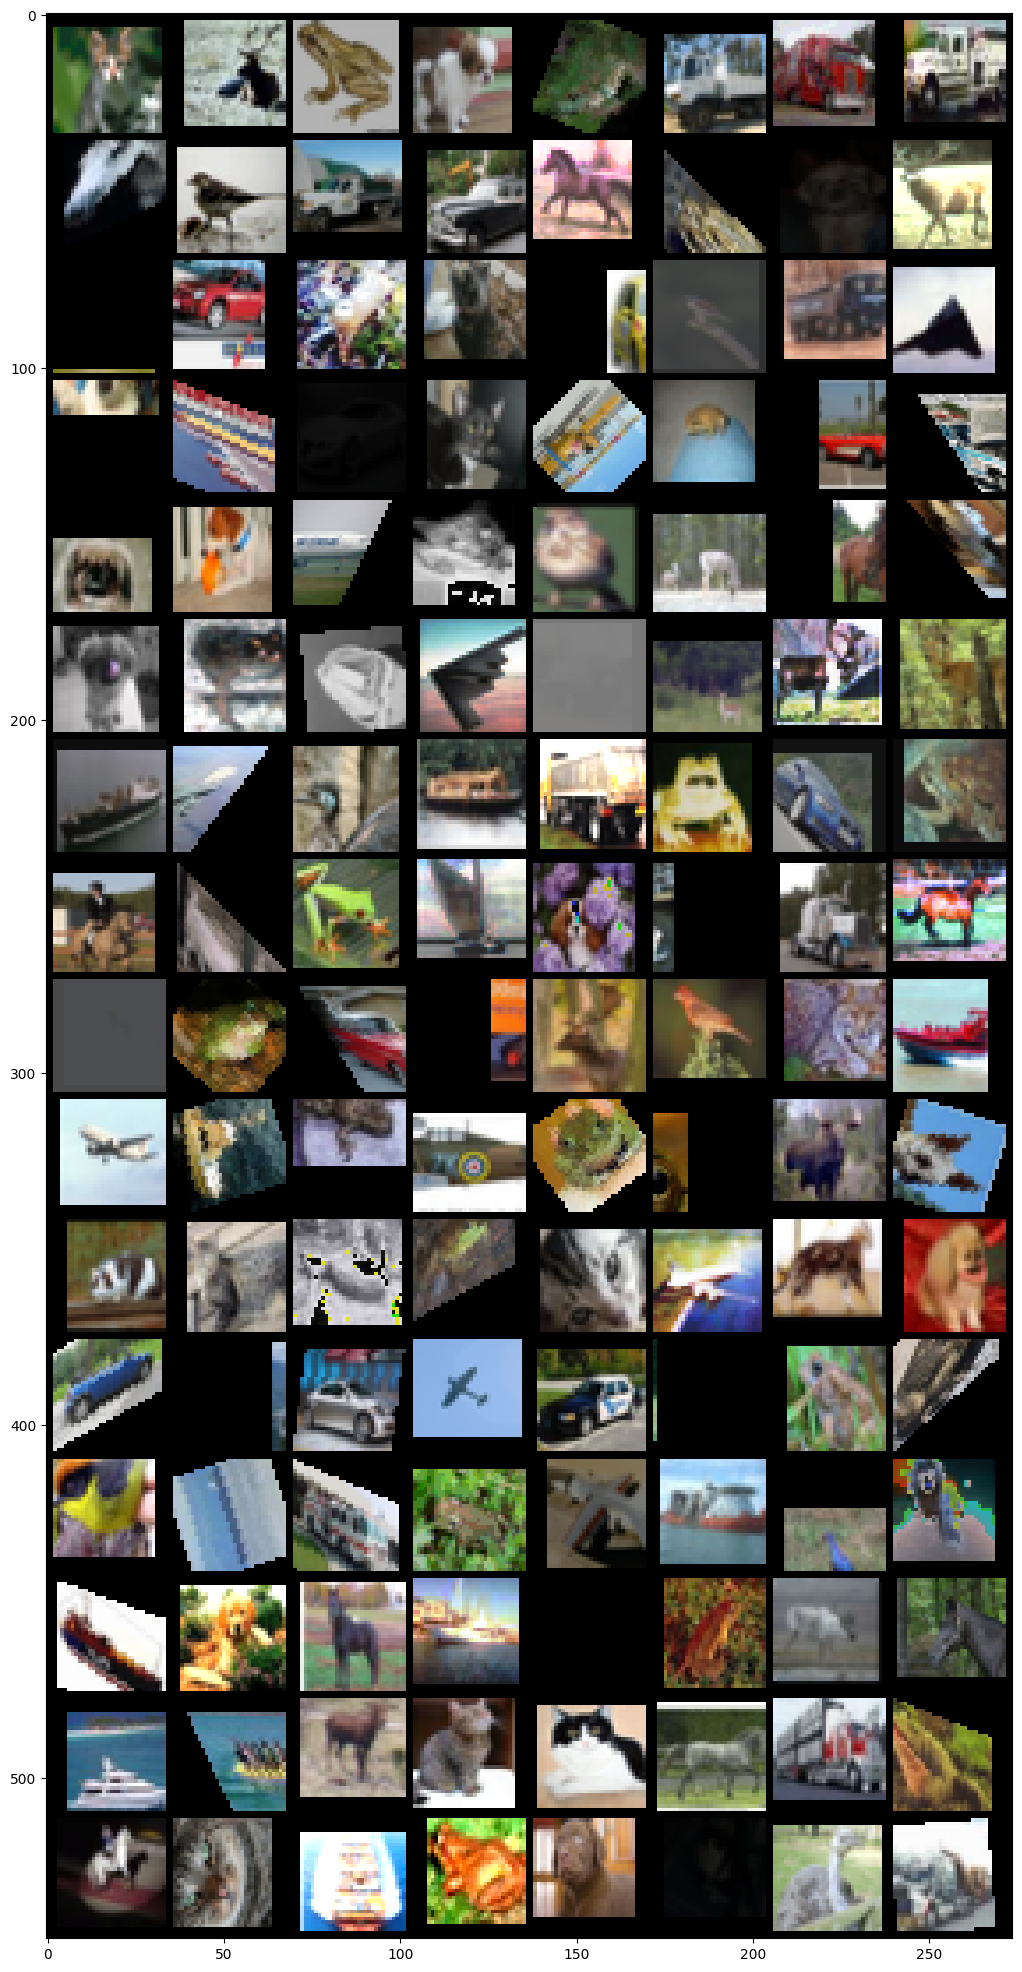

cat   deer  frog  dog   frog  truck truck truck horse bird  truck car   horse frog  dog   deer  bird  car   deer  cat   car   bird  truck plane dog   plane car   cat   plane frog  car   car   dog   dog   plane cat   bird  deer  horse cat   dog   frog  ship  plane car   deer  deer  deer  ship  plane bird  ship  truck frog  car   frog  horse deer  frog  ship  dog   ship  truck horse bird  frog  car   truck deer  bird  cat   ship  plane ship  frog  plane frog  frog  deer  dog   cat   cat   deer  frog  cat   plane cat   dog   car   ship  car   plane car   car   frog  frog  bird  ship  truck frog  plane ship  bird  dog   ship  dog   horse ship  horse frog  deer  horse ship  ship  deer  cat   cat   horse truck frog  horse cat   ship  frog  dog   cat   bird  truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 25))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(custom_trainloader)
# images, labels, confidences = next(dataiter)

# if training baseline model, uncomment this
dataiter = iter(baseline_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels 
# if isinstance(confidences, list):
#     # in case we have confidence 
#     confidences = confidences[1]
    
# print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=10, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=10)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    
    net.train()
    for i, (inputs, labels) in enumerate(baseline_trainloader):
#     for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
        # only when TA with soft labels is applied
#         if isinstance(confidences, list):
#             confidences = confidences[1]
            
        # get the inputs
#         inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)  
#         loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hard_loss:.3f}')

        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * correct / total: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = '/kaggle/working/cifar_net_ta_pytorch_100.pth'
torch.save(net.state_dict(), PATH)


Start Training...




Epoch 1 - Loss: 1.968 - Test Accuracy:  33.050

Processing time:  66.890636 seconds.



Epoch 2 - Loss: 1.632 - Test Accuracy:  51.600

Processing time:  43.446346 seconds.



Epoch 3 - Loss: 1.429 - Test Accuracy:  58.210

Processing time:  30.994406 seconds.



Epoch 4 - Loss: 1.302 - Test Accuracy:  31.140

Processing time:  31.407376 seconds.



Epoch 5 - Loss: 1.198 - Test Accuracy:  56.800

Processing time:  30.897118 seconds.



Epoch 6 - Loss: 1.132 - Test Accuracy:  56.410

Processing time:  31.995546 seconds.



Epoch 7 - Loss: 1.067 - Test Accuracy:  68.860

Processing time:  31.434802 seconds.



Epoch 8 - Loss: 1.020 - Test Accuracy:  64.250

Processing time:  31.696703 seconds.



Epoch 9 - Loss: 0.974 - Test Accuracy:  69.670

Processing time:  31.067138 seconds.



Epoch 10 - Loss: 0.925 - Test Accuracy:  75.510

Processing time:  30.932800 seconds.



Epoch 11 - Loss: 0.889 - Test Accuracy:  71.010

Processing time:  31.184686 seconds.



Epoch 12 - Loss: 0.860 - Test Accuracy:  79.720

Processing time:  30.679987 seconds.



Epoch 13 - Loss: 0.835 - Test Accuracy:  79.310

Processing time:  30.557346 seconds.



Epoch 14 - Loss: 0.806 - Test Accuracy:  77.760

Processing time:  31.503357 seconds.



Epoch 15 - Loss: 0.783 - Test Accuracy:  76.730

Processing time:  31.557773 seconds.



Epoch 16 - Loss: 0.768 - Test Accuracy:  81.010

Processing time:  31.288942 seconds.



Epoch 17 - Loss: 0.748 - Test Accuracy:  82.870

Processing time:  31.752846 seconds.



Epoch 18 - Loss: 0.732 - Test Accuracy:  80.400

Processing time:  30.586179 seconds.



Epoch 19 - Loss: 0.723 - Test Accuracy:  81.920

Processing time:  30.298814 seconds.



Epoch 20 - Loss: 0.707 - Test Accuracy:  83.260

Processing time:  30.322096 seconds.



Epoch 21 - Loss: 0.694 - Test Accuracy:  82.770

Processing time:  31.414412 seconds.



Epoch 22 - Loss: 0.688 - Test Accuracy:  83.050

Processing time:  31.476540 seconds.



Epoch 23 - Loss: 0.670 - Test Accuracy:  84.540

Processing time:  31.321616 seconds.



Epoch 24 - Loss: 0.663 - Test Accuracy:  85.010

Processing time:  30.360972 seconds.



Epoch 25 - Loss: 0.656 - Test Accuracy:  84.100

Processing time:  30.299121 seconds.



Epoch 26 - Loss: 0.648 - Test Accuracy:  84.170

Processing time:  30.460696 seconds.



Epoch 27 - Loss: 0.641 - Test Accuracy:  83.390

Processing time:  30.072955 seconds.



Epoch 28 - Loss: 0.618 - Test Accuracy:  85.960

Processing time:  32.133156 seconds.



Epoch 29 - Loss: 0.617 - Test Accuracy:  86.400

Processing time:  31.017674 seconds.



Epoch 30 - Loss: 0.610 - Test Accuracy:  85.830

Processing time:  30.452209 seconds.



Epoch 31 - Loss: 0.607 - Test Accuracy:  83.900

Processing time:  30.256306 seconds.



Epoch 32 - Loss: 0.596 - Test Accuracy:  86.410

Processing time:  31.703483 seconds.



Epoch 33 - Loss: 0.593 - Test Accuracy:  87.190

Processing time:  31.526686 seconds.



Epoch 34 - Loss: 0.583 - Test Accuracy:  87.110

Processing time:  31.245744 seconds.



Epoch 35 - Loss: 0.574 - Test Accuracy:  87.510

Processing time:  31.292556 seconds.



Epoch 36 - Loss: 0.568 - Test Accuracy:  86.450

Processing time:  31.488124 seconds.



Epoch 37 - Loss: 0.563 - Test Accuracy:  88.150

Processing time:  31.311178 seconds.



Epoch 38 - Loss: 0.561 - Test Accuracy:  87.860

Processing time:  30.818505 seconds.



Epoch 39 - Loss: 0.550 - Test Accuracy:  88.820

Processing time:  30.694860 seconds.



Epoch 40 - Loss: 0.543 - Test Accuracy:  89.820

Processing time:  30.620973 seconds.



Epoch 41 - Loss: 0.540 - Test Accuracy:  89.340

Processing time:  30.712564 seconds.



Epoch 42 - Loss: 0.538 - Test Accuracy:  89.740

Processing time:  30.325086 seconds.



Epoch 43 - Loss: 0.524 - Test Accuracy:  89.520

Processing time:  31.678327 seconds.



Epoch 44 - Loss: 0.518 - Test Accuracy:  89.830

Processing time:  30.502750 seconds.



Epoch 45 - Loss: 0.513 - Test Accuracy:  88.930

Processing time:  30.194139 seconds.



Epoch 46 - Loss: 0.506 - Test Accuracy:  89.890

Processing time:  31.342772 seconds.



Epoch 47 - Loss: 0.506 - Test Accuracy:  89.850

Processing time:  30.328922 seconds.



Epoch 48 - Loss: 0.495 - Test Accuracy:  90.830

Processing time:  30.385658 seconds.



Epoch 49 - Loss: 0.488 - Test Accuracy:  90.100

Processing time:  31.492568 seconds.



Epoch 50 - Loss: 0.487 - Test Accuracy:  89.930

Processing time:  31.410816 seconds.



Epoch 51 - Loss: 0.478 - Test Accuracy:  90.730

Processing time:  31.335422 seconds.



Epoch 52 - Loss: 0.483 - Test Accuracy:  90.270

Processing time:  31.126256 seconds.



Epoch 53 - Loss: 0.457 - Test Accuracy:  91.030

Processing time:  31.057639 seconds.



Epoch 54 - Loss: 0.455 - Test Accuracy:  91.570

Processing time:  31.403069 seconds.



Epoch 55 - Loss: 0.448 - Test Accuracy:  91.210

Processing time:  31.577625 seconds.



Epoch 56 - Loss: 0.445 - Test Accuracy:  90.790

Processing time:  31.513980 seconds.



Epoch 57 - Loss: 0.442 - Test Accuracy:  89.730

Processing time:  31.184763 seconds.



Epoch 58 - Loss: 0.436 - Test Accuracy:  91.110

Processing time:  31.332193 seconds.



Epoch 59 - Loss: 0.423 - Test Accuracy:  92.460

Processing time:  30.889801 seconds.



Epoch 60 - Loss: 0.420 - Test Accuracy:  92.280

Processing time:  32.233648 seconds.



Epoch 61 - Loss: 0.414 - Test Accuracy:  90.880

Processing time:  31.048737 seconds.



Epoch 62 - Loss: 0.410 - Test Accuracy:  92.120

Processing time:  32.688569 seconds.



Epoch 63 - Loss: 0.409 - Test Accuracy:  92.380

Processing time:  31.111815 seconds.



Epoch 64 - Loss: 0.398 - Test Accuracy:  93.100

Processing time:  30.965942 seconds.



Epoch 65 - Loss: 0.386 - Test Accuracy:  91.720

Processing time:  31.041564 seconds.



Epoch 66 - Loss: 0.382 - Test Accuracy:  92.680

Processing time:  31.335140 seconds.



Epoch 67 - Loss: 0.377 - Test Accuracy:  93.210

Processing time:  31.412622 seconds.



Epoch 68 - Loss: 0.369 - Test Accuracy:  92.300

Processing time:  32.188293 seconds.



Epoch 69 - Loss: 0.362 - Test Accuracy:  93.090

Processing time:  30.815951 seconds.



Epoch 70 - Loss: 0.354 - Test Accuracy:  92.800

Processing time:  31.367727 seconds.



Epoch 71 - Loss: 0.350 - Test Accuracy:  93.510

Processing time:  30.995107 seconds.



Epoch 72 - Loss: 0.346 - Test Accuracy:  93.600

Processing time:  31.038544 seconds.



Epoch 73 - Loss: 0.335 - Test Accuracy:  94.180

Processing time:  31.382528 seconds.



Epoch 74 - Loss: 0.329 - Test Accuracy:  93.830

Processing time:  31.205257 seconds.



Epoch 75 - Loss: 0.322 - Test Accuracy:  93.730

Processing time:  31.126933 seconds.



Epoch 76 - Loss: 0.317 - Test Accuracy:  94.220

Processing time:  31.399059 seconds.



Epoch 77 - Loss: 0.311 - Test Accuracy:  94.280

Processing time:  31.150549 seconds.



Epoch 78 - Loss: 0.304 - Test Accuracy:  94.270

Processing time:  31.257005 seconds.



Epoch 79 - Loss: 0.293 - Test Accuracy:  93.950

Processing time:  31.397270 seconds.



Epoch 80 - Loss: 0.290 - Test Accuracy:  94.500

Processing time:  31.675428 seconds.



Epoch 81 - Loss: 0.290 - Test Accuracy:  94.770

Processing time:  31.584986 seconds.



Epoch 82 - Loss: 0.283 - Test Accuracy:  95.020

Processing time:  31.242812 seconds.



Epoch 83 - Loss: 0.274 - Test Accuracy:  94.630

Processing time:  30.966633 seconds.



Epoch 84 - Loss: 0.270 - Test Accuracy:  95.100

Processing time:  31.107717 seconds.



Epoch 85 - Loss: 0.267 - Test Accuracy:  94.560

Processing time:  31.238572 seconds.



Epoch 86 - Loss: 0.263 - Test Accuracy:  94.580

Processing time:  31.345747 seconds.



Epoch 87 - Loss: 0.264 - Test Accuracy:  95.010

Processing time:  31.478310 seconds.



Epoch 88 - Loss: 0.254 - Test Accuracy:  95.170

Processing time:  30.981858 seconds.



Epoch 89 - Loss: 0.251 - Test Accuracy:  95.140

Processing time:  31.321755 seconds.



Epoch 90 - Loss: 0.246 - Test Accuracy:  95.180

Processing time:  31.257016 seconds.



Epoch 91 - Loss: 0.245 - Test Accuracy:  95.090

Processing time:  34.087890 seconds.



Epoch 92 - Loss: 0.243 - Test Accuracy:  95.290

Processing time:  31.540940 seconds.



Epoch 93 - Loss: 0.236 - Test Accuracy:  95.290

Processing time:  30.973730 seconds.



Epoch 94 - Loss: 0.239 - Test Accuracy:  95.340

Processing time:  31.335018 seconds.



Epoch 95 - Loss: 0.233 - Test Accuracy:  95.410

Processing time:  31.090336 seconds.



Epoch 96 - Loss: 0.240 - Test Accuracy:  95.420

Processing time:  31.069819 seconds.



Epoch 97 - Loss: 0.230 - Test Accuracy:  95.430

Processing time:  30.867892 seconds.



Epoch 98 - Loss: 0.230 - Test Accuracy:  95.550

Processing time:  31.275975 seconds.



Epoch 99 - Loss: 0.231 - Test Accuracy:  95.460

Processing time:  31.033926 seconds.



Epoch 100 - Loss: 0.225 - Test Accuracy:  95.470

Processing time:  31.316217 seconds.
Finished Training


Evaluate the model on Testset

In [10]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 95.47 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 87.71 %


Accuracy of the network on gaussian_noise dataset split 2: 76.16 %


Accuracy of the network on gaussian_noise dataset split 3: 61.06 %


Accuracy of the network on gaussian_noise dataset split 4: 54.58 %


Accuracy of the network on gaussian_noise dataset split 5: 47.41 %
Average accuracy for gaussian_noise dataset: 65.38 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 90.68 %


Accuracy of the network on shot_noise dataset split 2: 86.08 %


Accuracy of the network on shot_noise dataset split 3: 72.56 %


Accuracy of the network on shot_noise dataset split 4: 65.78 %


Accuracy of the network on shot_noise dataset split 5: 54.69 %
Average accuracy for shot_noise dataset: 73.96 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 92.51 %


Accuracy of the network on impulse_noise dataset split 2: 89.11 %


Accuracy of the network on impulse_noise dataset split 3: 84.33 %


Accuracy of the network on impulse_noise dataset split 4: 67.69 %


Accuracy of the network on impulse_noise dataset split 5: 48.54 %
Average accuracy for impulse_noise dataset: 76.44 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 95.31 %


Accuracy of the network on defocus_blur dataset split 2: 94.76 %


Accuracy of the network on defocus_blur dataset split 3: 93.63 %


Accuracy of the network on defocus_blur dataset split 4: 91.55 %


Accuracy of the network on defocus_blur dataset split 5: 86.42 %
Average accuracy for defocus_blur dataset: 92.33 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 80.67 %


Accuracy of the network on glass_blur dataset split 2: 81.54 %


Accuracy of the network on glass_blur dataset split 3: 83.62 %


Accuracy of the network on glass_blur dataset split 4: 67.68 %


Accuracy of the network on glass_blur dataset split 5: 70.65 %
Average accuracy for glass_blur dataset: 76.83 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 93.64 %


Accuracy of the network on motion_blur dataset split 2: 90.81 %


Accuracy of the network on motion_blur dataset split 3: 86.30 %


Accuracy of the network on motion_blur dataset split 4: 86.59 %


Accuracy of the network on motion_blur dataset split 5: 81.61 %
Average accuracy for motion_blur dataset: 87.79 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 92.70 %


Accuracy of the network on zoom_blur dataset split 2: 92.94 %


Accuracy of the network on zoom_blur dataset split 3: 91.71 %


Accuracy of the network on zoom_blur dataset split 4: 90.54 %


Accuracy of the network on zoom_blur dataset split 5: 87.42 %
Average accuracy for zoom_blur dataset: 91.06 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 92.86 %


Accuracy of the network on snow dataset split 2: 87.98 %


Accuracy of the network on snow dataset split 3: 88.02 %


Accuracy of the network on snow dataset split 4: 85.85 %


Accuracy of the network on snow dataset split 5: 83.68 %
Average accuracy for snow dataset: 87.68 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 93.08 %


Accuracy of the network on frost dataset split 2: 89.78 %


Accuracy of the network on frost dataset split 3: 83.42 %


Accuracy of the network on frost dataset split 4: 82.19 %


Accuracy of the network on frost dataset split 5: 74.14 %
Average accuracy for frost dataset: 84.52 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 95.46 %


Accuracy of the network on fog dataset split 2: 95.10 %


Accuracy of the network on fog dataset split 3: 94.60 %


Accuracy of the network on fog dataset split 4: 93.29 %


Accuracy of the network on fog dataset split 5: 86.85 %
Average accuracy for fog dataset: 93.06 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 95.47 %


Accuracy of the network on brightness dataset split 2: 95.23 %


Accuracy of the network on brightness dataset split 3: 94.92 %


Accuracy of the network on brightness dataset split 4: 94.56 %


Accuracy of the network on brightness dataset split 5: 93.93 %
Average accuracy for brightness dataset: 94.82 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 95.51 %


Accuracy of the network on contrast dataset split 2: 94.51 %


Accuracy of the network on contrast dataset split 3: 93.79 %


Accuracy of the network on contrast dataset split 4: 92.59 %


Accuracy of the network on contrast dataset split 5: 87.84 %
Average accuracy for contrast dataset: 92.85 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 92.84 %


Accuracy of the network on elastic_transform dataset split 2: 92.86 %


Accuracy of the network on elastic_transform dataset split 3: 91.58 %


Accuracy of the network on elastic_transform dataset split 4: 86.12 %


Accuracy of the network on elastic_transform dataset split 5: 79.45 %
Average accuracy for elastic_transform dataset: 88.57 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 93.91 %


Accuracy of the network on pixelate dataset split 2: 90.30 %


Accuracy of the network on pixelate dataset split 3: 85.55 %


Accuracy of the network on pixelate dataset split 4: 65.37 %


Accuracy of the network on pixelate dataset split 5: 46.29 %
Average accuracy for pixelate dataset: 76.28 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 89.91 %


Accuracy of the network on jpeg_compression dataset split 2: 85.47 %


Accuracy of the network on jpeg_compression dataset split 3: 83.94 %


Accuracy of the network on jpeg_compression dataset split 4: 81.26 %


Accuracy of the network on jpeg_compression dataset split 5: 78.53 %
Average accuracy for jpeg_compression dataset: 83.82 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 90.64 %


Accuracy of the network on speckle_noise dataset split 2: 82.90 %


Accuracy of the network on speckle_noise dataset split 3: 78.72 %


Accuracy of the network on speckle_noise dataset split 4: 68.23 %


Accuracy of the network on speckle_noise dataset split 5: 57.99 %
Average accuracy for speckle_noise dataset: 75.70 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 95.32 %


Accuracy of the network on gaussian_blur dataset split 2: 93.60 %


Accuracy of the network on gaussian_blur dataset split 3: 92.23 %


Accuracy of the network on gaussian_blur dataset split 4: 89.82 %


Accuracy of the network on gaussian_blur dataset split 5: 83.27 %
Average accuracy for gaussian_blur dataset: 90.85 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 94.19 %


Accuracy of the network on spatter dataset split 2: 91.80 %


Accuracy of the network on spatter dataset split 3: 87.77 %


Accuracy of the network on spatter dataset split 4: 92.29 %


Accuracy of the network on spatter dataset split 5: 88.32 %
Average accuracy for spatter dataset: 90.87 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 94.09 %


Accuracy of the network on saturate dataset split 2: 92.00 %


Accuracy of the network on saturate dataset split 3: 94.94 %


Accuracy of the network on saturate dataset split 4: 93.81 %


Accuracy of the network on saturate dataset split 5: 92.15 %
Average accuracy for saturate dataset: 93.40 %
Average Robust Accuracy: 85.06 %


TA (soft) Trained (Latest: accuracy=95.60%)

In [11]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=10)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar_net_exp003_tpu.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")




Baseline Model (without TA)

In [12]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=10)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar_net_baseline.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")

Baseline (TA trained)

In [13]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=10)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar_net_ta_baseline.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")